## MiniBatch **Experiment**

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline
plt.style.use("dark_background")

from sklearn.model_selection import train_test_split

In [15]:
import seaborn as sns

df_iris = sns.load_dataset("iris")

In [16]:
from sklearn.preprocessing import LabelEncoder
#transformamos las etiquetas (y) de los datos a ser números desde 0 a n_clases-1
label_enc = LabelEncoder()

labels = label_enc.fit_transform(df_iris.species)

X = torch.tensor(df_iris.iloc[:,0:4].values).float() #matriz de características
y = torch.tensor(labels).long() #vector de las etiquetas transformadas a números (tipo de dato long() -> entero) #podiamos tambien haber hecho df.iris[df.iris.species=="setosa"] == 1 y así

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [18]:
train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

In [19]:
def get_data_loader(batch_size):
    
    train_loader = DataLoader(train_data,
                         batch_size=batch_size,
                         shuffle=True)

    test_loader = DataLoader(test_data,
                        batch_size=test_data.tensors[0].shape[0])
    
    return train_loader, test_loader

In [20]:
# batch_size = 16 #suelen ser potencias de 2

# train_loader = DataLoader(train_data,
#                          batch_size=batch_size,
#                          shuffle=True)

# test_loader = DataLoader(test_data,
#                         batch_size=test_data.tensors[0].shape[0])
# #train_data.tensors[0] accede a las características X
# #para predicciones del modelo, los lotes son individuales

Si el último batch se queda incompleto, usaremos el parámetro `drop_last=True`

In [21]:
class Model(nn.Module):
    
    def __init__(self):
        
        super().__init__()
        self.inp = nn.Linear(4, 64)
        self.hid = nn.Linear(64, 64)
        self.out = nn.Linear(64, 3)
    
    def forward(self, x):
        
        x = F.relu(self.inp(x))
        x = F.relu(self.hid(x))
        x = self.out(x)
        
        return x
        

In [22]:
def create_model():
    
    model = Model()
    loss_func = nn.CrossEntropyLoss()
    optim = torch.optim.SGD(params=model.parameters(),
                       lr=0.001)
    
    return model, loss_func, optim

In [23]:
n_epochs = 500

def train_model(model, loss_func, optim):
    
    train_accs = []
    test_accs = []
    losses = []
    
    for epoch in range(n_epochs):
        
        
        batch_accs = []
        batch_loss = []
        
        for (X_batch, y_batch) in train_loader:
            
            y_hat = model(X_batch)
            
            loss = loss_func(y_hat, y_batch)
            
            optim.zero_grad()
            loss.backward()
            optim.step()
            

            batch_accs.append(100*torch.mean((torch.argmax(y_hat, axis=1) == y_batch).float()).item())
            batch_loss.append(loss.item())
        
        #al final de cada epoch
        train_accs.append(np.mean(batch_accs))
        losses.append(np.mean(batch_loss))
        
        #test
        X_test, y_test = next(iter(test_loader)) #extraemos los datos del generador
        preds = model(X_test)
        test_accs.append(100*torch.mean((torch.argmax(preds, axis=1) == y_test).float()).item())
        
    
    return train_accs, test_accs, losses

Variaremos el tamaño de lote desde $2^2=4$ hasta $2^6=64$

In [41]:
batch_sizes = list(range(2,7))

In [42]:
from tqdm import tqdm

In [43]:
exp_train_accs = np.zeros((n_epochs, len(batch_sizes)))
exp_test_accs = np.zeros((n_epochs, len(batch_sizes)))
exp_losses = np.zeros((n_epochs, len(batch_sizes)))

In [45]:
for idx, batch_size in tqdm(enumerate(batch_sizes)):
    train_loader, test_loader = get_data_loader(2**batch_size)
    model, loss_func, optim = create_model()
    train_accs, test_accs, losses = train_model(model, loss_func, optim)
    
    exp_train_accs[:,idx] = train_accs
    exp_test_accs[:,idx] = test_accs
    exp_losses[:,idx] = losses

5it [00:26,  5.25s/it]


In [46]:
batch_sizes

[2, 3, 4, 5, 6]

In [36]:
# plt.style.use("default")

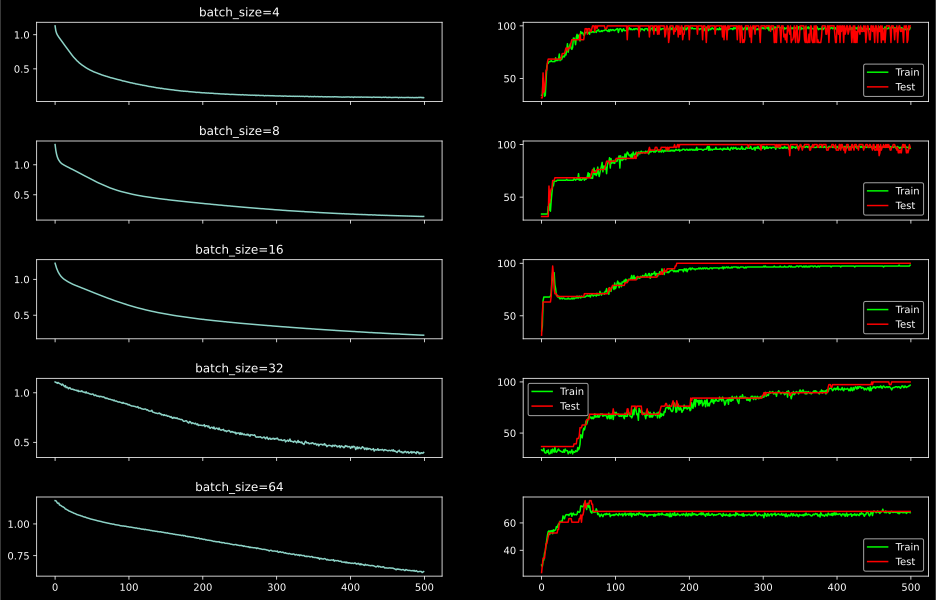

In [47]:
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(16,10), sharex=True)
plt.subplots_adjust(hspace=0.5)

for idx in range(len(batch_sizes)):
    
    axs[idx,0].plot(exp_losses[:,idx])
    axs[idx,0].set_title(f"batch_size={2**batch_sizes[idx]}")
    axs[idx,1].plot(exp_train_accs[:,idx], color="lime")
    axs[idx,1].plot(exp_test_accs[:,idx], color="red")
    axs[idx,1].legend(["Train", "Test"])
    

In [48]:
plt.style.use("dark_background")

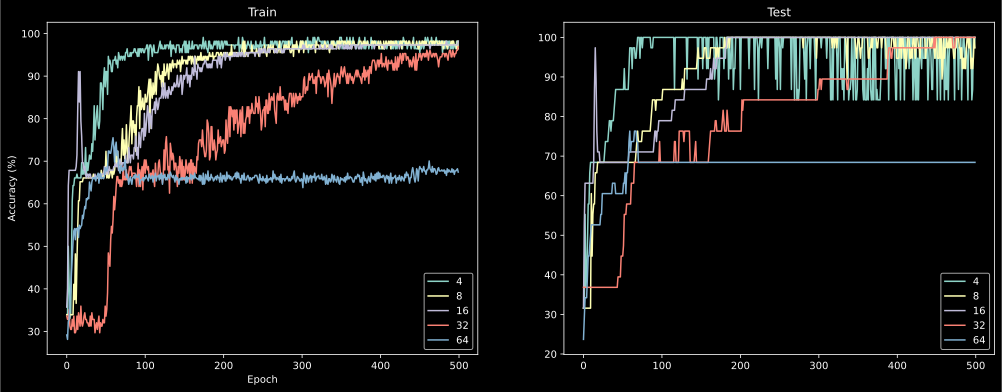

In [62]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(17,6))

axs[0].plot(exp_train_accs)
axs[0].set_title("Train")
axs[0].legend([2**size for size in batch_sizes]);
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Accuracy (%)")
axs[1].plot(exp_test_accs);
axs[1].legend([2**size for size in batch_sizes]);
axs[1].set_title("Test");


https://stats.stackexchange.com/questions/164876/what-is-the-trade-off-between-batch-size-and-number-of-iterations-to-train-a-neu

### - Valores de `batch_size` **muy altos** causan una menor precisión, y un mayor costo computacional, y además tardan mucho más en aprender realmente

### - Valores de `batch_size` **más pequeños** tienden a obtener mejores resultados, y ser más rápidos & eficientes. 
*La razón de por qué generaliza esta técnica es debido a que hace segmentaciones equitativas de los datos, los cuales pasan por la red para ajustarse, y a pesar de cambiar el paradigma de error constantemente, las funciones a minimizar serán cercanas o tendrán algo en común debido a que los datos tienen patrones similares los cuales aprovecha la red para aprender*

In [1]:
# 1) Why are the minibatch sizes specified in powers of 2? That's partly because DL is developed by math/computer nerds,
#    but it's also partly an attempt to optimize computation speed, because computer memory comes in powers of two.
#    But 2**N is not a specific requirement. Adjust the code to use batch sizes corresponding to six linearly spaced 
#    integers between 2 and 50.
# 
# 2) Why did I ask you to set the learning rate to .001? Try this experiment again using higher and lower learning rates.
#    What do you conclude about batch sizes and learning rate?
# 